In [1]:
import sys
import time

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx, to_dense_adj

from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.model import select_model, Model
from graph_deep_decoder.architecture import GraphDecoder, GraphDeepDecoder, Ups
from graph_deep_decoder.graph_clustering import MultiResGraphClustering

from graph_deep_decoder.baselines import GCNN, GAT, KronAE

# %matplotlib qt

DATASET_PATH = './dataset/temperatures2003_3months.npz'
MAX_SIGNALS = 3
SEED = 0
SAVE = False
PATH = '../results/temperatures/'
FILE_PREF = 'denoise_'

plt.rcParams['image.cmap'] = 'Spectral_r'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

print(device)

cuda:0


COMMENTS:
- We have a clear best performance in terms of soft l1 norm error with GCG when using the Sigmoid, but the classification error rate is worst. En tasa ganamos si no cogemos el mejor epoch si no el último. Esta diferencia cuando cogemos el último epoch es incluso mayor si usamos la Cross Entropy.
- With ReLU and Sigmoid GD seems to work better with gamma=0 than with gamma=.1. I should check this and the usage of batch normalization.

## Auxiliary functions

In [2]:
def get_best_err(err):
    median_err = np.median(err, axis=1)
    mean_err = np.mean(err, axis=1)

    best_epochs = np.argmin(median_err, axis=2)
    best_epochs_mean = np.argmin(mean_err, axis=2)
    best_med_err = np.zeros((len(N_P), len(Exps)))
    best_mean_err = np.zeros((len(N_P), len(Exps)))
    for i in range(len(N_P)):
        for j in range(len(Exps)):
            best_med_err[i, j] = median_err[i, j, best_epochs[i, j]]
            best_mean_err[i, j] = mean_err[i, j, best_epochs_mean[i, j]]
    return best_mean_err, best_med_err, best_epochs_mean, best_epochs


def plot_noise_err(err, legend, ylabel):
    fig = plt.figure()
    plt.semilogy(N_P, err, linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Normalized noise power',fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xlim([N_P[0], N_P[-1]])
    # plt.ylim([1e-3, 0.2])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    return fig


def print_err(best_err, weights):
    print('N_P:', N_P)
    for j, exp in enumerate(Exps):
        text = '{} ({}): '.format(exp['legend'], weights[j])
        for i, n_p in enumerate(N_P):
            text += '\t{:.4f}'.format(best_err[i, j]) 
        print(text)

def plot_iter_err(err, label):
    figs = []
    for i, n_p in enumerate(N_P):
        err_np = err[i]
        figs.append(plt.figure())
        plt.semilogy(err_np.T)
        plt.grid(True, which='both')
        plt.legend(legend)
        plt.title('{}: {}'.format(label, n_p))
        plt.xlim(left=0, right=err.shape[-1])
        plt.tight_layout()
        
    return figs


## Load dataset

Number of nodes: 2708
Number of edges: 10556
Number of classes: 7
WConn Comp: 78


Text(0.5, 1.0, 'Original graph')

<Figure size 432x288 with 0 Axes>

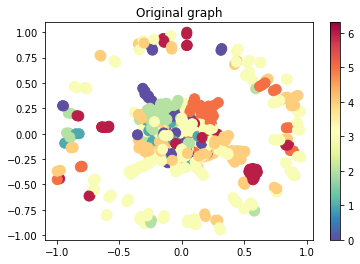

In [3]:
dataset = Planetoid(root='./tmp/Cora', name='Cora')
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of classes: {dataset.num_classes}')

A = to_dense_adj(data.edge_index).numpy()[0,:,:]
L = np.diag(np.sum(A, axis=0)) - A
lambdas, V = np.linalg.eigh(L)
lambdas = np.real(lambdas)
print('WConn Comp:', np.sum(np.abs(lambdas) <= 1e-6))

labels = data.y

# D_inv_sqrt = np.sqrt(1/np.diag(np.sum(A, axis=0)))
# A = D_inv_sqrt@A@D_inv_sqrt
S = A

G = Graph(A)
G.set_coordinates()
plt.figure()
G.plot_signal(labels.numpy())
plt.title('Original graph')


## Using signal associtated with label 0 - As MSE problem

## Set the expetiments

In [4]:
# Get clusters

# clts_nodes = [[300, 1000], [1000, 2000], [250, 500, 1500],
#               [300, 1000, 2000], [500, 1000, 2000]]

# clts_nodes = [[300, 1000, 2000]]

clts_nodes = [ [300, 1000, 1600, 2000]]

clts = []
for i, nodes in enumerate(clts_nodes):
    clts_nodes[i] = nodes + [G.N]*2
    print('Clustering:', clts_nodes[i])
    clt = MultiResGraphClustering(G, clts_nodes[i], clts_nodes[i][0], link_fun='average')
    clts.append(clt)

# # Add more clusters
# clt_aux = [[300], [400], [400, 1000]]
# for nodes in clt_aux:
#     nodes += [G.N]*2
#     clts_nodes.append(nodes)
#     print('Clustering:', nodes)
#     clt = MultiResGraphClustering(G, nodes, nodes[0], link_fun='average')
#     clts.append(clt)

Clustering: [300, 1000, 1600, 2000, 2708, 2708]


## Plot clusrtering

In [5]:
N_P = [.1]

# Model parameters
epochs =  500
lr = 0.001
loss = nn.MSELoss
last_ft = 1

Exps = [
        # With None
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': None,
         'loss': loss(reduction='none'), 'legend': 'GCNN'},

        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': last_ft, 'last_act': None,
         'loss': loss(reduction='none'), 'legend': 'GAT'},

        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [last_ft],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [last_ft],
         'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .1, 
         'loss': loss(reduction='none'), 'legend': 'GD'},


        # With Sigmoid
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},

        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': last_ft, 'last_act': nn.Sigmoid(),
         'loss': loss(reduction='none'), 'legend': 'GAT'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [last_ft],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [last_ft],
         'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .1, 
         'loss': loss(reduction='none'), 'legend': 'GD'},


        # With ReLU
        {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.ReLU(),
         'loss': loss(reduction='none'), 'legend': 'GCNN'},

        {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'last_fts': last_ft, 'last_act': nn.ReLU(),
         'loss': loss(reduction='none'), 'legend': 'GAT'},

        # Our models
        {'type': 'DD', 'ups': Ups.U_MAT, 'nodes': [G.N]*4, 'fts': [100]*3 + [last_ft],
         'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': 1, 'bn': False,
         'h_params': {'type': 'FixedH', 'S': 'A', 'hs': [.3, .5, .2], 'H_norm': False},
         'loss': loss(reduction='none'), 'legend': 'GCG'},

        {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 1600, 2000] + [G.N]*2, 'fts': [50]*5 + [last_ft],
         'af': nn.ReLU(), 'laf':  nn.ReLU(), 'w_std': 1, 'in_std': .5, 'bn': False, 'gamma': .1, 
         'loss': loss(reduction='none'), 'legend': 'GD'},
        ]



legend = [exp['legend'] for _, exp in enumerate(Exps)]


# Compute needed matrices
for exp in Exps:
    # if exp['type'] == '2LD':
    #     exp['H'] = H_norm if exp['H_norm'] else H
    # elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
    if exp['type'] == 'DD' and exp['legend'] == 'GD':
        # clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
        idx = clts_nodes.index(exp['nodes'])
        clt = clts[idx]
        exp['nodes'] = clt.sizes
        exp['Us'] = clt.Us
        exp['As'] = clt.As
        # idx = clts_nodes.index(exp['nodes'])
        # exp['nodes'] = clts[idx].sizes
        # exp['Us'] = clts[idx].Us
        # exp['As'] = clts[idx].As
    elif exp['type'] == 'DD' and exp['legend'] == 'GCG':
        H = utils.create_filter(S, exp['h_params'])
        exp['Us'] =[H]*(len(exp['nodes'])-2) + [None]
        exp['As'] = []


In [8]:
unique_labels = np.unique(labels)

print('Labels:', unique_labels)
n_labels = len(unique_labels)
n_signals = 5

mse = np.zeros((len(N_P), n_labels*n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_labels*n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)

    for l, label in enumerate(unique_labels):
        x = np.zeros(G.N)
        x[labels == label] = 1

        for j in range(n_signals):
            idx = l*n_signals + j
            x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)
            # xx_nn[i,j,:] = x_n

            for k, exp in enumerate(Exps):
                print(exp['legend'],  end=' ')
                model = select_model(exp, x_n, epochs, lr, device)

                if type(model) == Model:
                    weights[k] = model.count_params()
                    mse[i, idx, k], err[i, idx, k], _ = model.fit(x_n, x, class_val=True, device=device)
                else:
                    model.fit(x_n)
                    _, err_non_train = model.test(x)
                    err[i, idx, k] = np.repeat(err_non_train, epochs)

                print('{} ({},{}): err rate: {:.3f} '.format(exp['legend'], l ,j, err[i, idx, k].min()))

            # print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Labels: [0 1 2 3 4 5 6]
Noise: 0.1
GCNN GCNN (0,0): err rate: 0.05465287924744189 
GAT GAT (0,0): err rate: 0.06019202241441235 
GCG GCG (0,0): err rate: 0.0771787281264551 
GD WARNING: degree matrix is singular. N: 1000
GD (0,0): err rate: 0.06314623210346326 
GCNN GCNN (0,0): err rate: 0.04652880260255188 
GAT GAT (0,0): err rate: 0.06019202241441235 
GCG GCG (0,0): err rate: 0.05908419378101826 
GD WARNING: degree matrix is singular. N: 1000
GD (0,0): err rate: 0.07348596601514146 
GCNN GCNN (0,0): err rate: 0.056129984091967344 
GAT GAT (0,0): err rate: 0.05834564135875553 
GCG GCG (0,0): err rate: 0.07127030874835327 
GD WARNING: degree matrix is singular. N: 1000
GD (0,0): err rate: 0.05908419378101826 
GCNN GCNN (0,1): err rate: 0.05280649819178507 
GAT GAT (0,1): err rate: 0.051698669558390975 
GCG GCG (0,1): err rate: 0.07090103253722191 
GD WARNING: degree matrix is singular. N: 1000
GD (0,1): err rate: 0.06314623210346326 
GCNN GCNN (0,1): err rate: 0.04763663123594597 
GAT 

### Plot results

In [14]:
best_mean_err, _, _, _ = get_best_err(err)
fixed_mean_err = np.mean(err, axis=1)[:, :, -1]
fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error (Best epoch)')
fig4 = plot_noise_err(fixed_mean_err, legend, 'Mean Error (Last epoch)')


print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)
print('Err all 0:', np.sum(x)/x.size)

print_err(best_mean_err, weights)
print()
print_err(fixed_mean_err, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')



<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])
<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])


Err Noise: 0.10598227474150665
Err all 0: 0.06646971935007386
N_P: [0.1]
GCNN (5926.0): 	0.0413
GAT (16101.0): 	0.0557
GCG (20100.0): 	0.0707
GD (10050.0): 	0.0548
GCNN (5926.0): 	0.0355
GAT (16101.0): 	0.0521
GCG (20100.0): 	0.0444
GD (10050.0): 	0.0568
GCNN (5926.0): 	0.0997
GAT (16101.0): 	0.0581
GCG (20100.0): 	0.0743
GD (10050.0): 	0.0625

N_P: [0.1]
GCNN (5926.0): 	0.0463
GAT (16101.0): 	0.0878
GCG (20100.0): 	0.0739
GD (10050.0): 	0.0548
GCNN (5926.0): 	0.0480
GAT (16101.0): 	0.0921
GCG (20100.0): 	0.0512
GD (10050.0): 	0.0624
GCNN (5926.0): 	0.1052
GAT (16101.0): 	0.0872
GCG (20100.0): 	0.0779
GD (10050.0): 	0.0637


## All labels in the same signal - Gaussian noise

In [6]:
N_P = [.1, .3]
n_signals = 25
x = labels.numpy()

mse = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x_n = ds.GraphSignal.add_noise(x, n_p)

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                mse[i, j, k], err[i, j, k], _ = model.fit(x_n, x, class_val=True, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)


        print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.1
0 WARNING: degree matrix is singular. N: 1000
1 WARNING: degree matrix is singular. N: 1000
2 WARNING: degree matrix is singular. N: 1000
3 WARNING: degree matrix is singular. N: 1000
4 WARNING: degree matrix is singular. N: 1000
5 WARNING: degree matrix is singular. N: 1000
6 WARNING: degree matrix is singular. N: 1000
7 WARNING: degree matrix is singular. N: 1000
8 WARNING: degree matrix is singular. N: 1000
9 WARNING: degree matrix is singular. N: 1000
10 WARNING: degree matrix is singular. N: 1000
11 WARNING: degree matrix is singular. N: 1000
12 WARNING: degree matrix is singular. N: 1000
13 WARNING: degree matrix is singular. N: 1000
14 WARNING: degree matrix is singular. N: 1000
15 WARNING: degree matrix is singular. N: 1000
16 WARNING: degree matrix is singular. N: 1000
17 WARNING: degree matrix is singular. N: 1000
18 WARNING: degree matrix is singular. N: 1000
19 WARNING: degree matrix is singular. N: 1000
20 WARNING: degree matrix is singular. N: 1000
21 WARNING: 

### Plot results

N_P: [0.1, 0.3]
GCNN (5926.0): 	0.1174	0.1218
GAT (16101.0): 	0.1197	0.1209
GCG (20100.0): 	0.1404	0.1300
GD (10050.0): 	0.0968	0.0932
GCNN (5926.0): 	0.0945	0.0976
GAT (16101.0): 	0.1204	0.1220
GCG (20100.0): 	0.0801	0.0801
GD (10050.0): 	0.0801	0.0801
GCNN (5926.0): 	0.1202	0.1209
GAT (16101.0): 	0.1186	0.1210
GCG (20100.0): 	0.1370	0.1376
GD (10050.0): 	0.0981	0.0987

N_P: [0.1, 0.3]
GCNN (5926.0): 	0.1073	0.1410
GAT (16101.0): 	0.0596	0.1255
GCG (20100.0): 	0.2103	0.2482
GD (10050.0): 	0.2307	0.2386
GCNN (5926.0): 	0.5663	0.5708
GAT (16101.0): 	0.0614	0.1287
GCG (20100.0): 	0.5726	0.5729
GD (10050.0): 	0.5893	0.5893
GCNN (5926.0): 	0.4289	0.3782
GAT (16101.0): 	0.0590	0.1256
GCG (20100.0): 	0.2171	0.2496
GD (10050.0): 	0.2662	0.3014


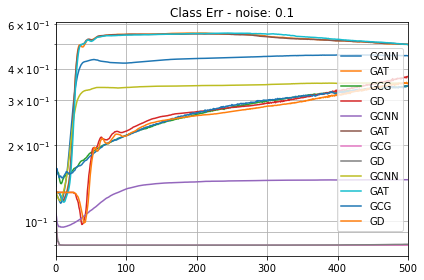

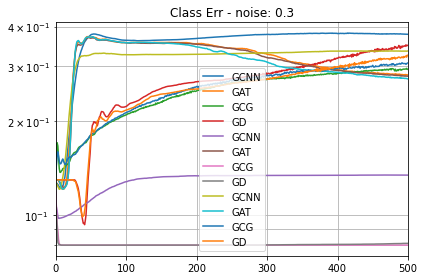

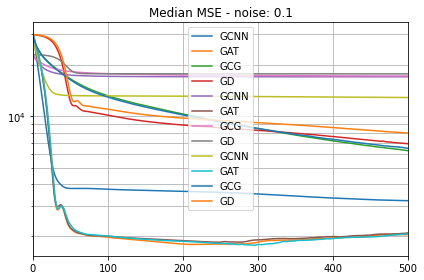

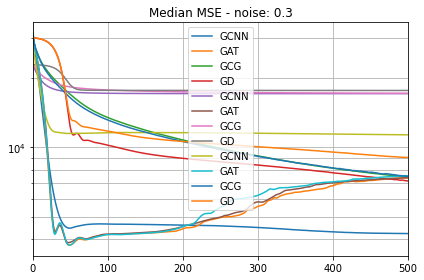

In [7]:
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_mean_mse, legend, 'Median Error')

print_err(best_mean_err, weights)
print()
print_err(best_mean_mse, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

N_P: [0.1, 0.3]
GCNN (5926.0): 	0.1174	0.1218
GAT (16101.0): 	0.1197	0.1209
GCG (20100.0): 	0.1404	0.1300
GD (10050.0): 	0.0968	0.0932
GCNN (5926.0): 	0.0945	0.0976
GAT (16101.0): 	0.1204	0.1220
GCG (20100.0): 	0.0801	0.0801
GD (10050.0): 	0.0801	0.0801
GCNN (5926.0): 	0.1202	0.1209
GAT (16101.0): 	0.1186	0.1210
GCG (20100.0): 	0.1370	0.1376
GD (10050.0): 	0.0981	0.0987

N_P: [0.1, 0.3]
GCNN (5926.0): 	0.1073	0.1410
GAT (16101.0): 	0.0596	0.1255
GCG (20100.0): 	0.2103	0.2482
GD (10050.0): 	0.2307	0.2386
GCNN (5926.0): 	0.5663	0.5708
GAT (16101.0): 	0.0614	0.1287
GCG (20100.0): 	0.5726	0.5729
GD (10050.0): 	0.5893	0.5893
GCNN (5926.0): 	0.4289	0.3782
GAT (16101.0): 	0.0590	0.1256
GCG (20100.0): 	0.2171	0.2496
GD (10050.0): 	0.2662	0.3014


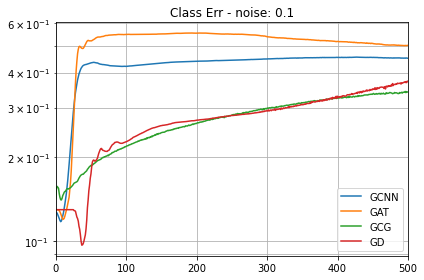

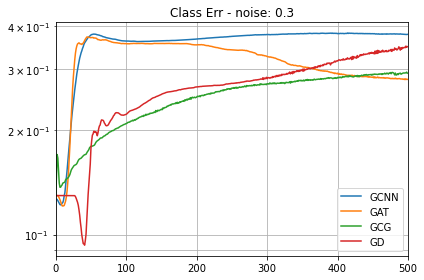

In [8]:
# Last Act Funct: None
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,:4,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

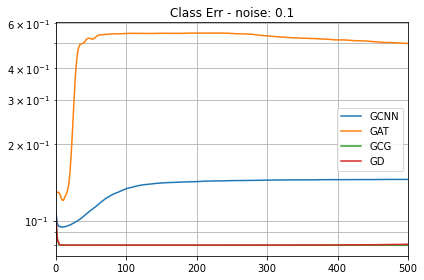

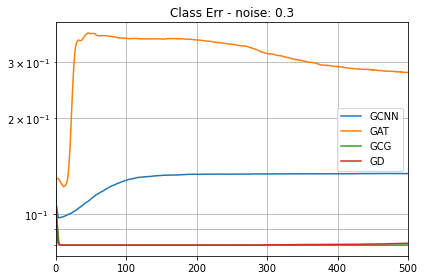

In [9]:
# Last Act Funct: Sigmoig
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,4:8,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

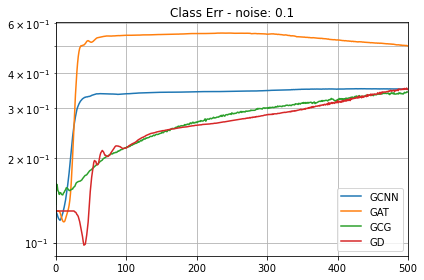

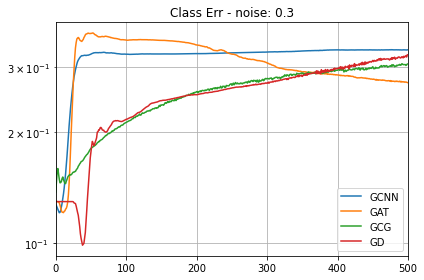

In [10]:
# Last Act Funct: ReLU
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

figs = plot_iter_err(np.mean(err[:,:,8:,:], axis=1), 'Class Err - noise')
# figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

## All labels in the same signal - Bernoulli noise

In [12]:
N_P = [.1, .3]
n_signals = 25

x = labels.numpy()

mse = np.zeros((len(N_P), n_signals, len(Exps), epochs))
err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
weights = np.zeros(len(Exps))
start_time = time.time()
for i, n_p in enumerate(N_P):
    print('Noise:', n_p)
    for j in range(n_signals):
        x_n = ds.GraphSignal.change_labels(x, n_p)

        for k, exp in enumerate(Exps):
            model = select_model(exp, x_n, epochs, lr, device)

            if type(model) == Model:
                weights[k] = model.count_params()
                mse[i, j, k], err[i, j, k], _ = model.fit(x_n, x, class_val=True, device=device)
            else:
                model.fit(x_n)
                _, err_non_train = model.test(x)
                err[i, j, k] = np.repeat(err_non_train, epochs)


            print(j, end=' ')
    print()

print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.1


TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=__int64, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

### Plot results

<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])
<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])


Err Noise: 0.10487444608567208
Err all 0: 0.3020679468242245
N_P: [0.1]
GCNN (5926.0): 	0.0519
GAT (16101.0): 	0.0666
GCG (20100.0): 	0.0631
GD (10050.0): 	0.0931
N_P: [0.1]
GCNN (5926.0): 	238.3432
GAT (16101.0): 	76.0276
GCG (20100.0): 	202.7967
GD (10050.0): 	344.4939


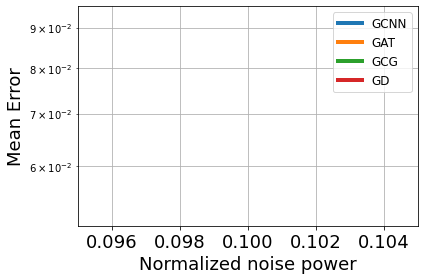

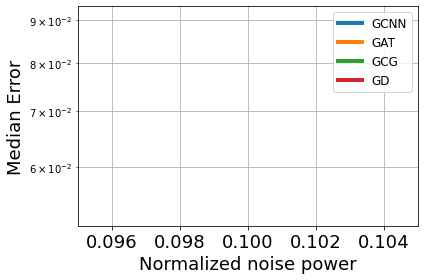

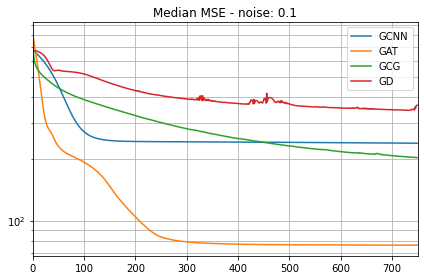

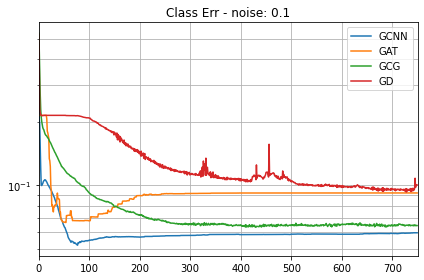

In [ ]:
best_mean_err, _, _, _ = get_best_err(err)
mse_norm = mse/np.linalg.norm(x)**2
best_mean_mse, _, _, _ = get_best_err(mse_norm)

# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_mean_mse, legend, 'Median Error')

print_err(best_mean_err, weights)
print()
print_err(best_mean_mse, weights)

figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')
figs = plot_iter_err(np.mean(mse, axis=1), 'Median MSE - noise')

## Using signal associtated with label 0 - As Class problem

In [21]:
# N_P = [.1]
# lr = 0.001
# loss=nn.CrossEntropyLoss
# last_ft = 2
# Exps = [

#         # {'type': 'GAT', 'fts': 70, 'A': A, 'heads': 3, 'legend': 'GAT'},
    
#         # [[300, 1000], [400, 1000], [500, 1000], [750, 1000], [1000, 2000], [250, 500, 1500],
#         #       [300, 1000, 2000], [400, 1000, 2000], [500, 1000, 2000]]

#         # With SIGMOID
#         # {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [400, 1000] + [G.N]*2, 'fts': [70]*3 + [2],
#         #  'af': nn.ReLU(), 'laf':  nn.Sigmoid(), 'w_std': 1, 'in_std': .1, 'bn': False, 'K': None,
#         #  'loss': loss(reduction='none'), 'legend': 'GD'},


#         # {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': 2, 'last_act': None,
#         #  'loss': loss(reduction='none'), 'legend': 'GCNN'},

#         {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.ReLU(),
#          'loss': loss(reduction='none'), 'legend': 'GCNN'},
#         {'type': 'GCNN', 'fts': 75, 'A': A, 'last_fts': last_ft, 'last_act': nn.Sigmoid(),
#          'loss': loss(reduction='none'), 'legend': 'GCNN'},


#         # # CURRENT BEST: GD (7600.0): 	0.0693
#         {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
#          'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': 1, 'bn': False, 'K': None,
#          'gamma': 0, 'loss': loss(reduction='none'), 'legend': 'GD'},
        
#         # GD (7600.0): 	0.0733
#         {'type': 'DD', 'ups': Ups.U_MEAN, 'nodes': [300, 1000, 2000] + [G.N]*2, 'fts': [50]*4 + [2],
#          'af': nn.ReLU(), 'laf':  None, 'w_std': 1, 'in_std': 1, 'bn': False, 'K': None,
#          'gamma': .1, 'loss': loss(reduction='none'), 'legend': 'GD'},



#         ]

# # Model parameters
# epochs =  1000

# legend = [exp['legend'] for _, exp in enumerate(Exps)]

# # Create filter H
# h_params = {'type': 'BLH', 'S': 'A', 'firsts': True, 'k': 0.1, 'H_norm': False}
# H = utils.create_filter(S, h_params)
# H_norm = H/np.linalg.norm(H)

# for exp in Exps:
#     # if exp['type'] == '2LD':
#     #     exp['H'] = H_norm if exp['H_norm'] else H
#     # elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MEAN:
#     if exp['type'] == 'DD':
#     #     # clt = MultiResGraphClustering(G, exp['nodes'], exp['nodes'][0], link_fun='average')
#         idx = clts_nodes.index(exp['nodes'])
#         exp['nodes'] = clts[idx].sizes
#         exp['Us'] = clts[idx].Us
#         exp['As'] = clts[idx].As
#     # elif exp['type'] == 'DD' and exp['ups'] is Ups.U_MAT:
#         # exp['Us'] = [H_norm] if exp['H_norm'] else [H]
#         # exp['Us'] = exp['Us']*(len(exp['nodes'])-2) + [None] 
#         # exp['As'] = []

In [23]:
# n_signals = 25

# x = np.zeros(G.N)
# x[labels == 0] = 1

# # Good but inverted
# x_1hot = np.zeros((G.N, 2))
# # x_1hot[x == 1, 0] = 1
# # x_1hot[x != 1, 1] = 1

# x_1hot[x != 1, 0] = 1
# x_1hot[x == 1, 1] = 1

# xx_nn = np.zeros((len(N_P), n_signals, G.N))
# cross = np.zeros((len(N_P), n_signals, len(Exps), epochs))
# err = np.zeros((len(N_P), n_signals, len(Exps), epochs))
# weights = np.zeros(len(Exps))
# start_time = time.time()
# for i, n_p in enumerate(N_P):
#     print('Noise:', n_p)
#     for j in range(n_signals):

#         x_n = ds.GraphSignal.add_bernoulli_noise(x, n_p)

#         xx_nn[i,j,:] = x_n
#         x_n_1hot = np.zeros((G.N, 2))
#         # x_n_1hot[x_n == 1, 0] = 1
#         # x_n_1hot[x_n != 1, 1] = 1

#         x_n_1hot[x_n != 1, 0] = 1
#         x_n_1hot[x_n == 1, 1] = 1

#         for k, exp in enumerate(Exps):
#             print(exp['legend'], end=' ')
#             # Change arch to use 1hot input?
#             model = select_model(exp, x_n_1hot, epochs, lr, device)

#             if type(model) == Model:
#                 weights[k] = model.count_params()
#                 cross[i, j, k], err[i, j, k], _ = model.fit(x_n_1hot, x_1hot, device=device)
#             else:
#                 model.fit(x_n)
#                 _, err_non_train = model.test(x)
#                 err[i, j, k] = np.repeat(err_non_train, epochs)

#             print('j:', j, 'cross:', cross[i, j, k].min(), 'err rate:', err[i, j, k].min())

#         # print(j, end=' ')
#     print()

# print('\n--- {} minutes ---'.format((time.time()-start_time)/60))

Noise: 0.1
GCNN j: 0 cross: 1877.0425701141357 err rate: 0.1296159501071088
GCNN j: 0 cross: 1004.2427967488766 err rate: 0.04468242154689506
GD WARNING: degree matrix is singular. N: 1000
j: 0 cross: 724.8216279005294 err rate: 0.07496307085966691
GD WARNING: degree matrix is singular. N: 1000
j: 0 cross: 717.181422598007 err rate: 0.07976366160437465
GD WARNING: degree matrix is singular. N: 1000
j: 0 cross: 596.7147403623617 err rate: 0.06831609905930236
GCNN j: 1 cross: 1765.5957284145989 err rate: 0.056129984091967344
GCNN j: 1 cross: 1008.4981251358986 err rate: 0.04948301229160279
GD WARNING: degree matrix is singular. N: 1000
j: 1 cross: 751.065243594214 err rate: 0.07570162328192964
GD WARNING: degree matrix is singular. N: 1000
j: 1 cross: 761.7217944446114 err rate: 0.07865583297098055
GD WARNING: degree matrix is singular. N: 1000
j: 1 cross: 692.5906987854798 err rate: 0.07680945191532373
GCNN j: 2 cross: 1753.5751079210313 err rate: 0.04689807881368324
GCNN j: 2 cross: 99

<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])
<ipython-input-2-6e538a903a3b>:23: UserWarning: Attempting to set identical left == right == 0.1 results in singular transformations; automatically expanding.
  plt.xlim([N_P[0], N_P[-1]])


Err all 0: 0.129615952732644
Err Noise: 0.10635155096011817
N_P: [0.1]
GCNN (6077.0): 	0.0925
GCNN (6077.0): 	0.0510
GD (7600.0): 	0.0718
GD (7600.0): 	0.0780
GD (7600.0): 	0.0751
N_P: [0.1]
GCNN (6077.0): 	1014.8958
GCNN (6077.0): 	1002.2957
GD (7600.0): 	751.3205
GD (7600.0): 	741.8570
GD (7600.0): 	689.5141


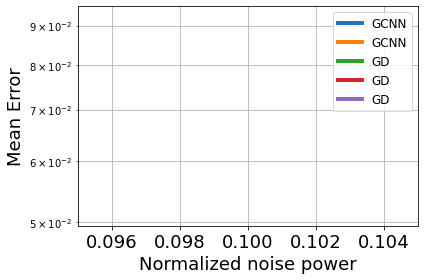

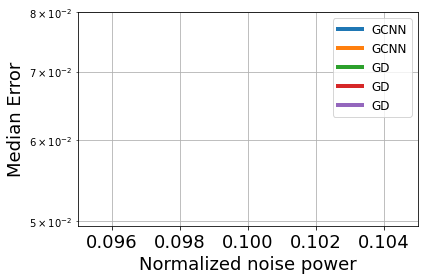

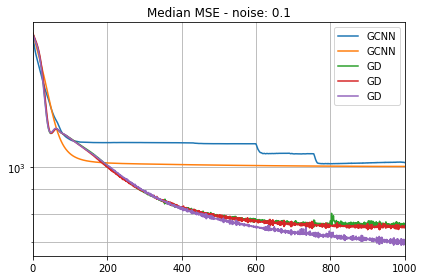

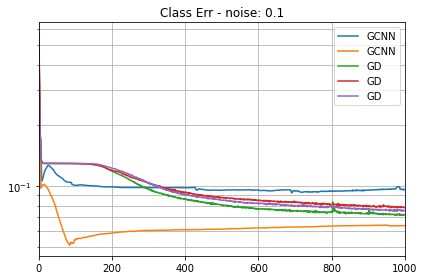

In [24]:
# best_mean_err, best_med_err, _, _ = get_best_err(err)
# fig3 = plot_noise_err(best_mean_err, legend, 'Mean Error')
# fig4 = plot_noise_err(best_med_err, legend, 'Median Error')
# # fig3.savefig(PATH + 'denoise_temp_all_pn.eps')
# # fig4.savefig(PATH + 'denoise_temp_all_pn.eps')

# print('Err all 0:', np.sum(x)/x.size)
# print('Err Noise:', np.sum(np.abs(x-x_n))/x.size)

# print_err(best_mean_err, weights)

# best_mean_cross, _, _, _ = get_best_err(cross)
# print_err(best_mean_cross, weights)

# figs = plot_iter_err(np.mean(cross, axis=1), 'Median MSE - noise')
# figs = plot_iter_err(np.mean(err, axis=1), 'Class Err - noise')


In [25]:
plt.show()